In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Install Required Libraries
!pip install transformers scikit-learn pandas torch peft

In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from peft import LoraConfig, get_peft_model

# Load LLM

In [5]:
# Load BioBERT
model_name = "dmis-lab/biobert-base-cased-v1.1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=34)  # Placeholder for `num_labels`

# GPU Check
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Load File

In [6]:
# Load Pre-split Datasets
train_path = "/content/drive/MyDrive/P2/T1.2/Dataset/LT-LLM-train.csv"
val_path = "/content/drive/MyDrive/P2/T1.2/Dataset/LT-LLM-val.csv"
test_path = "/content/drive/MyDrive/P2/T1.2/Dataset/LT-LLM-test.csv"

train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)
test_data = pd.read_csv(test_path)

# Encode Disease Labels
label_encoder = LabelEncoder()
train_data['encoded_labels'] = label_encoder.fit_transform(train_data['disease_label'])
val_data['encoded_labels'] = label_encoder.transform(val_data['disease_label'])
test_data['encoded_labels'] = label_encoder.transform(test_data['disease_label'])

num_classes = len(label_encoder.classes_)

# LoRA (Low-Rank Adaptation)

In [7]:
from peft import LoraConfig, get_peft_model

# Configure LoRA for BioBERT
lora_config = LoraConfig(
    r=32,  # Low-rank adaptation rank
    lora_alpha=64,  # Scaling factor
    target_modules=["query", "key", "value", "dense"],  # LoRA applied to attention layers
    lora_dropout=0.2,  # Dropout rate for regularization
    task_type="SEQ_CLS"  # Sequence classification task
)

model = get_peft_model(model, lora_config)
print("LoRA applied successfully to BioBERT!")

LoRA applied successfully to BioBERT!


# Tokenize Symptoms

In [8]:
# Tokenize Symptoms
def tokenize_texts(texts):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=128, return_tensors="pt")

train_encodings = tokenize_texts(train_data['symptoms'])
val_encodings = tokenize_texts(val_data['symptoms'])
test_encodings = tokenize_texts(test_data['symptoms'])

# Convert Labels to Tensors
train_labels = torch.tensor(train_data['encoded_labels'].tolist())
val_labels = torch.tensor(val_data['encoded_labels'].tolist())
test_labels = torch.tensor(test_data['encoded_labels'].tolist())

# Dataset Class for Fine-Tuning
class SymptomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

# Create PyTorch Datasets
train_dataset = SymptomDataset(train_encodings, train_labels)
val_dataset = SymptomDataset(val_encodings, val_labels)

# Fine-tuning BioBERT with LoRA

In [9]:
# Fine-Tuning BioBERT
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    logging_strategy="steps",  # Enable logging after a fixed number of steps
    logging_steps=10,  # Log training loss every 10 steps
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=128,
    num_train_epochs=6,
    weight_decay=0.001,
    logging_dir="./logs",
    save_strategy="epoch",
    save_total_limit=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [10]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss
1,0.101500,0.064368
2,0.006700,0.033611
3,0.012400,0.029141
4,0.047900,0.023186
5,0.001400,0.023355
6,0.016600,0.022844


TrainOutput(global_step=17754, training_loss=0.11064749461815027, metrics={'train_runtime': 2108.5462, 'train_samples_per_second': 269.384, 'train_steps_per_second': 8.42, 'total_flos': 2.6687929284809856e+16, 'train_loss': 0.11064749461815027, 'epoch': 6.0})

# Evaluation

In [11]:
def predict_diseases_batch(model, encodings, label_encoder, batch_size=32):
    """
    Predict diseases in batches to avoid CUDA out-of-memory errors.

    Args:
        model: The fine-tuned model.
        encodings: Tokenized input data.
        label_encoder: Label encoder for decoding predictions.
        batch_size: Number of samples per batch.

    Returns:
        predictions: Array of numeric predictions.
        predicted_labels: Array of disease labels.
    """
    model.eval()
    predictions = []

    # Process inputs in batches
    for i in range(0, len(encodings['input_ids']), batch_size):
        batch_inputs = {key: val[i:i+batch_size].to(device) for key, val in encodings.items()}
        with torch.no_grad():
            outputs = model(**batch_inputs)
            logits = outputs.logits
            batch_predictions = torch.argmax(logits, dim=-1).cpu().numpy()
            predictions.extend(batch_predictions)

    # Convert numeric predictions to disease labels
    predicted_labels = label_encoder.inverse_transform(predictions)
    return np.array(predictions), np.array(predicted_labels)


In [12]:
# Evaluate the Model's Performance
# Generate predictions using the predict_diseases_batch function
predictions, predicted_labels = predict_diseases_batch(model, test_encodings, label_encoder)

test_report = classification_report(
    test_data['encoded_labels'], predictions, target_names=label_encoder.classes_, output_dict=True
)
print("Test Report:")
print(pd.DataFrame(test_report))

# Save Classification Report to CSV
test_report_df = pd.DataFrame(test_report).transpose()
test_report_path = "/content/drive/MyDrive/P2/T1.2/Dataset/LLM/BioBERT-class.csv"
test_report_df.to_csv(test_report_path, index=True)
print(f"Classification report saved to {test_report_path}")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Report:
           accident cerebrovascular  affect labile  aphasia     asthma  \
precision                  1.000000       1.000000      1.0   0.973684   
recall                     0.921053       0.986842      1.0   0.973684   
f1-score                   0.958904       0.993377      1.0   0.973684   
support                   38.000000      76.000000     38.0  76.000000   

           benign prostatic hypertrophy  biliary calculus  carcinoma breast  \
precision                      0.987013          0.991511          0.996753   
recall                         1.000000          0.951140          1.000000   
f1-score                       0.993464          0.970906          0.998374   
support                       76.000000        614.000000        614.000000   

           carcinoma colon  carcinoma of lung   cirrhosis  ...  pancreatitis  \
precision         0.999187           1.000000    0.988710  ...      0.752475   
recall            1.000000           0.999797    0.998371  .

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Figure size 1800x800 with 0 Axes>

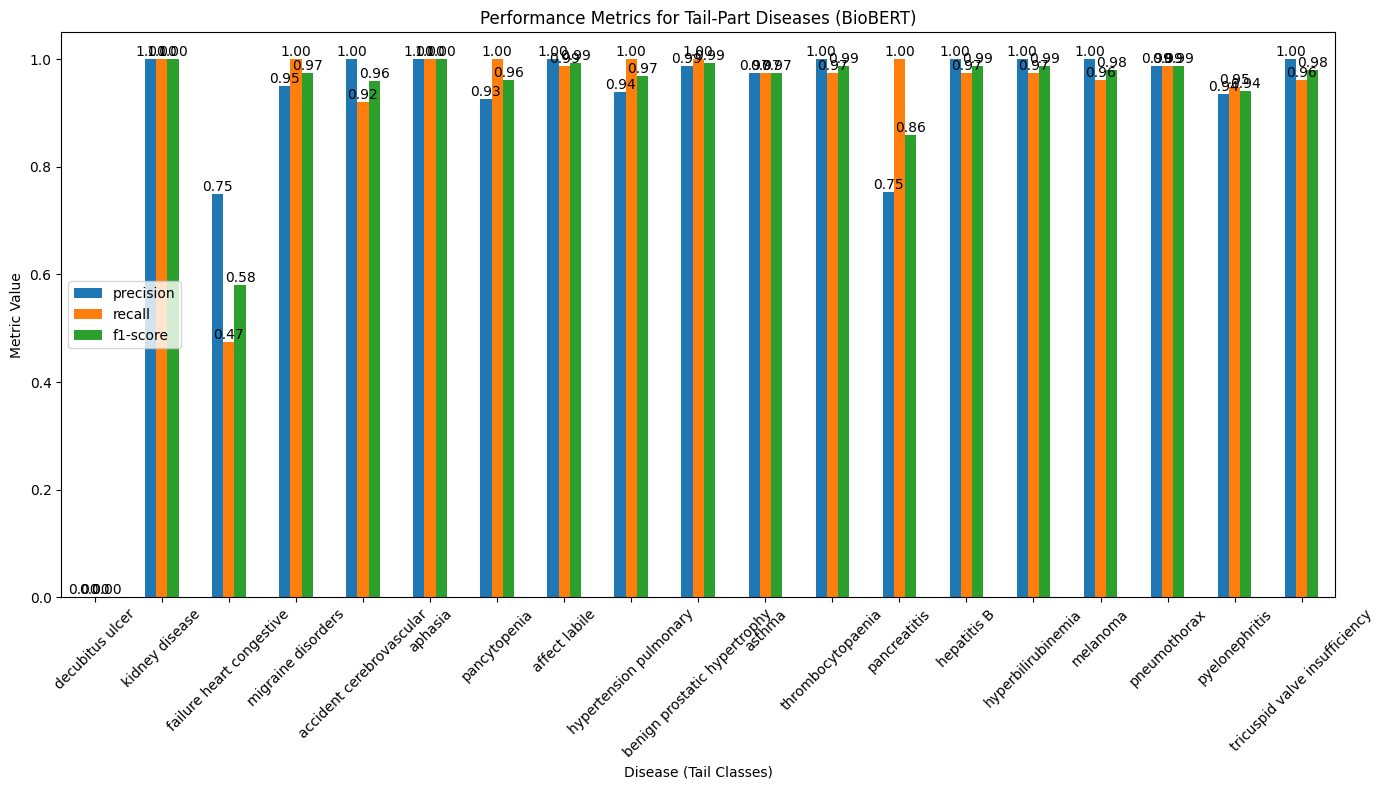

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Generate Classification Report for the Test Set
test_report = classification_report(
    test_data['encoded_labels'],
    predictions,  # Predictions from the BioBERT model
    target_names=label_encoder.classes_,
    output_dict=True
)

# Convert classification report to DataFrame
test_report_df = pd.DataFrame(test_report).transpose()

# Define tail-part diseases
tail_part_diseases = [
    "decubitus ulcer", "kidney disease", "failure heart congestive", "migraine disorders", "accident cerebrovascular",
    "aphasia", "pancytopenia", "affect labile", "hypertension pulmonary", "benign prostatic hypertrophy",
    "asthma", "thrombocytopaenia", "pancreatitis", "hepatitis B", "hyperbilirubinemia",
    "melanoma", "pneumothorax", "pyelonephritis", "tricuspid valve insufficiency"
]

# Filter only tail-part diseases present in the report
tail_part_diseases_present = [disease for disease in tail_part_diseases if disease in test_report_df.index]

# Extract metrics for tail-part diseases
tail_metrics = test_report_df.loc[tail_part_diseases_present, ["precision", "recall", "f1-score"]]

# Plot the metrics
plt.figure(figsize=(18, 8))
ax = tail_metrics.plot(kind='bar', figsize=(14, 8), legend=True)

# Annotate values on the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

# Add titles and labels
plt.title("Performance Metrics for Tail-Part Diseases (BioBERT)")
plt.xlabel("Disease (Tail Classes)")
plt.ylabel("Metric Value")
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


# Confusion Matrix

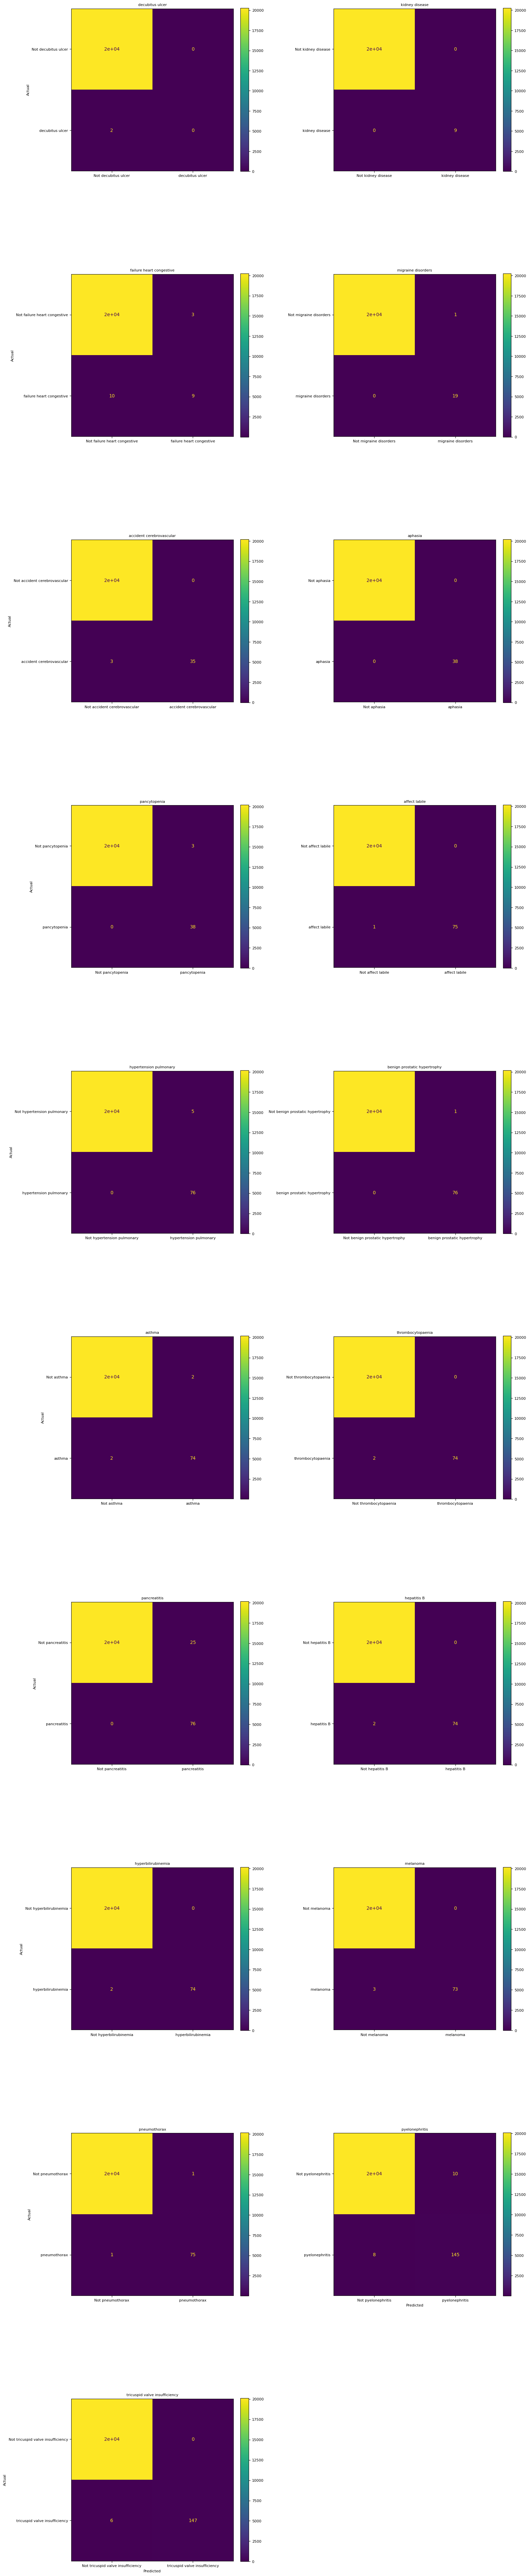

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ensure only existing diseases are considered
tail_part_diseases_present = [disease for disease in tail_part_diseases if disease in label_encoder.classes_]

# Plot settings
num_plots_per_row = 2
plot_size = (8, 8)

plt.figure(figsize=(plot_size[0] * num_plots_per_row, plot_size[1] * ((len(tail_part_diseases_present) + num_plots_per_row - 1) // num_plots_per_row)))

for i, disease in enumerate(tail_part_diseases_present):
    # Get the disease index
    disease_idx = list(label_encoder.classes_).index(disease)

    # Convert test_labels to binary for the specific disease
    y_test_binary = (test_data['encoded_labels'].to_numpy() == disease_idx).astype(int)
    y_pred_binary = (predictions == disease_idx).astype(int)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test_binary, y_pred_binary, labels=[0, 1])

    # Plot the confusion matrix
    ax = plt.subplot((len(tail_part_diseases_present) + num_plots_per_row - 1) // num_plots_per_row, num_plots_per_row, i + 1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not " + disease, disease])
    disp.plot(cmap='viridis', xticks_rotation='horizontal', ax=ax, colorbar=False)
    cbar = plt.colorbar(disp.im_, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)
    ax.set_title(f"{disease}", fontsize=8)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_xlabel("Predicted", fontsize=8)
    ax.set_ylabel("Actual", fontsize=8)
    if i % num_plots_per_row != 0:
        ax.set_ylabel('')
    if i < len(tail_part_diseases_present) - num_plots_per_row:
        ax.set_xlabel('')

plt.tight_layout()
plt.show()


# Head-part disease:


<Figure size 1800x800 with 0 Axes>

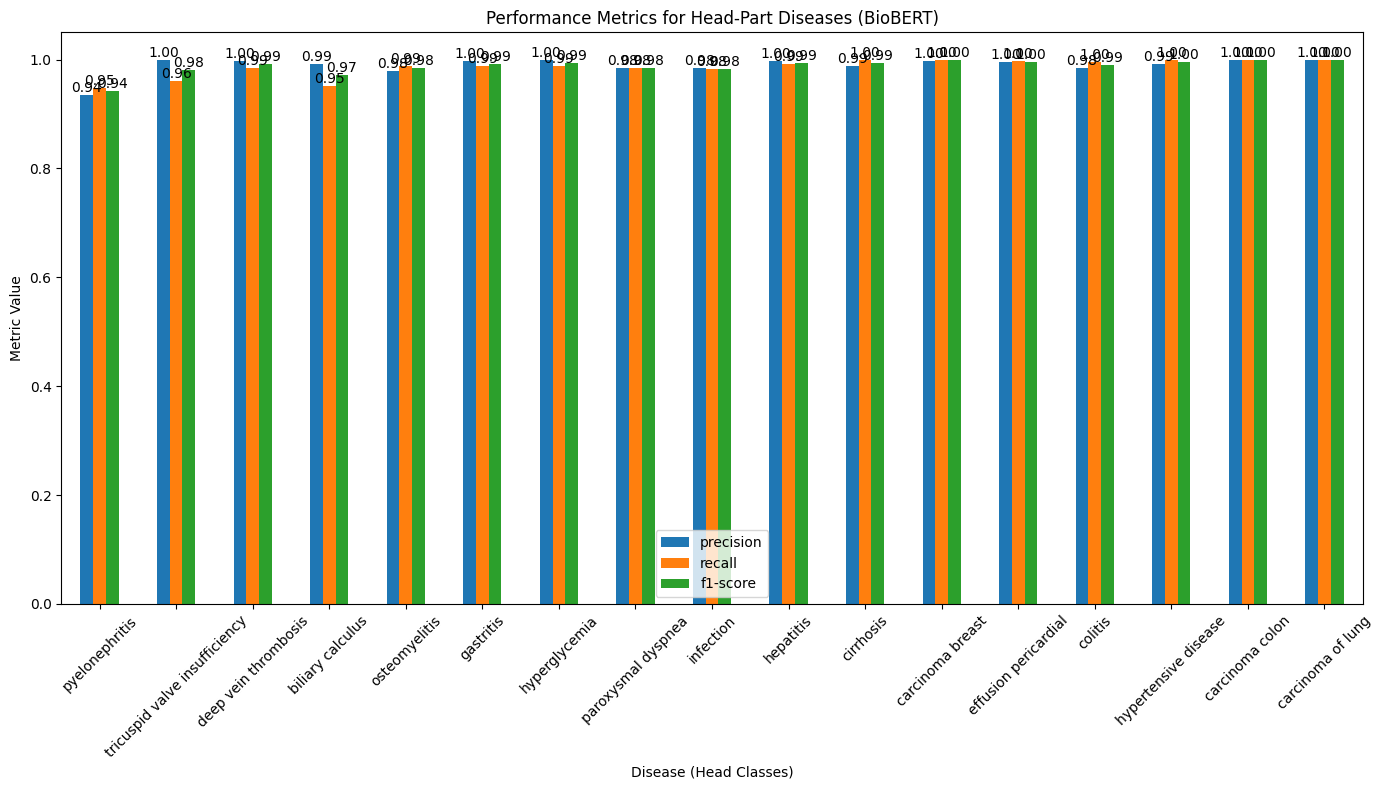

In [15]:
# Define head-part diseases
head_part_diseases = [
    "pyelonephritis", "tricuspid valve insufficiency", "deep vein thrombosis", "biliary calculus", "osteomyelitis",
    "gastritis", "hyperglycemia", "paroxysmal dyspnea", "infection", "hepatitis",
    "cirrhosis", "carcinoma breast", "effusion pericardial", "colitis", "hypertensive disease",
    "carcinoma colon", "carcinoma of lung"
]

# Filter only head-part diseases present in the report
head_part_diseases_present = [disease for disease in head_part_diseases if disease in test_report_df.index]

# Extract metrics for head-part diseases
head_metrics = test_report_df.loc[head_part_diseases_present, ["precision", "recall", "f1-score"]]

# Plot the metrics
plt.figure(figsize=(18, 8))
ax = head_metrics.plot(kind='bar', figsize=(14, 8), legend=True)

# Annotate values on the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

# Add titles and labels
plt.title("Performance Metrics for Head-Part Diseases (BioBERT)")
plt.xlabel("Disease (Head Classes)")
plt.ylabel("Metric Value")
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


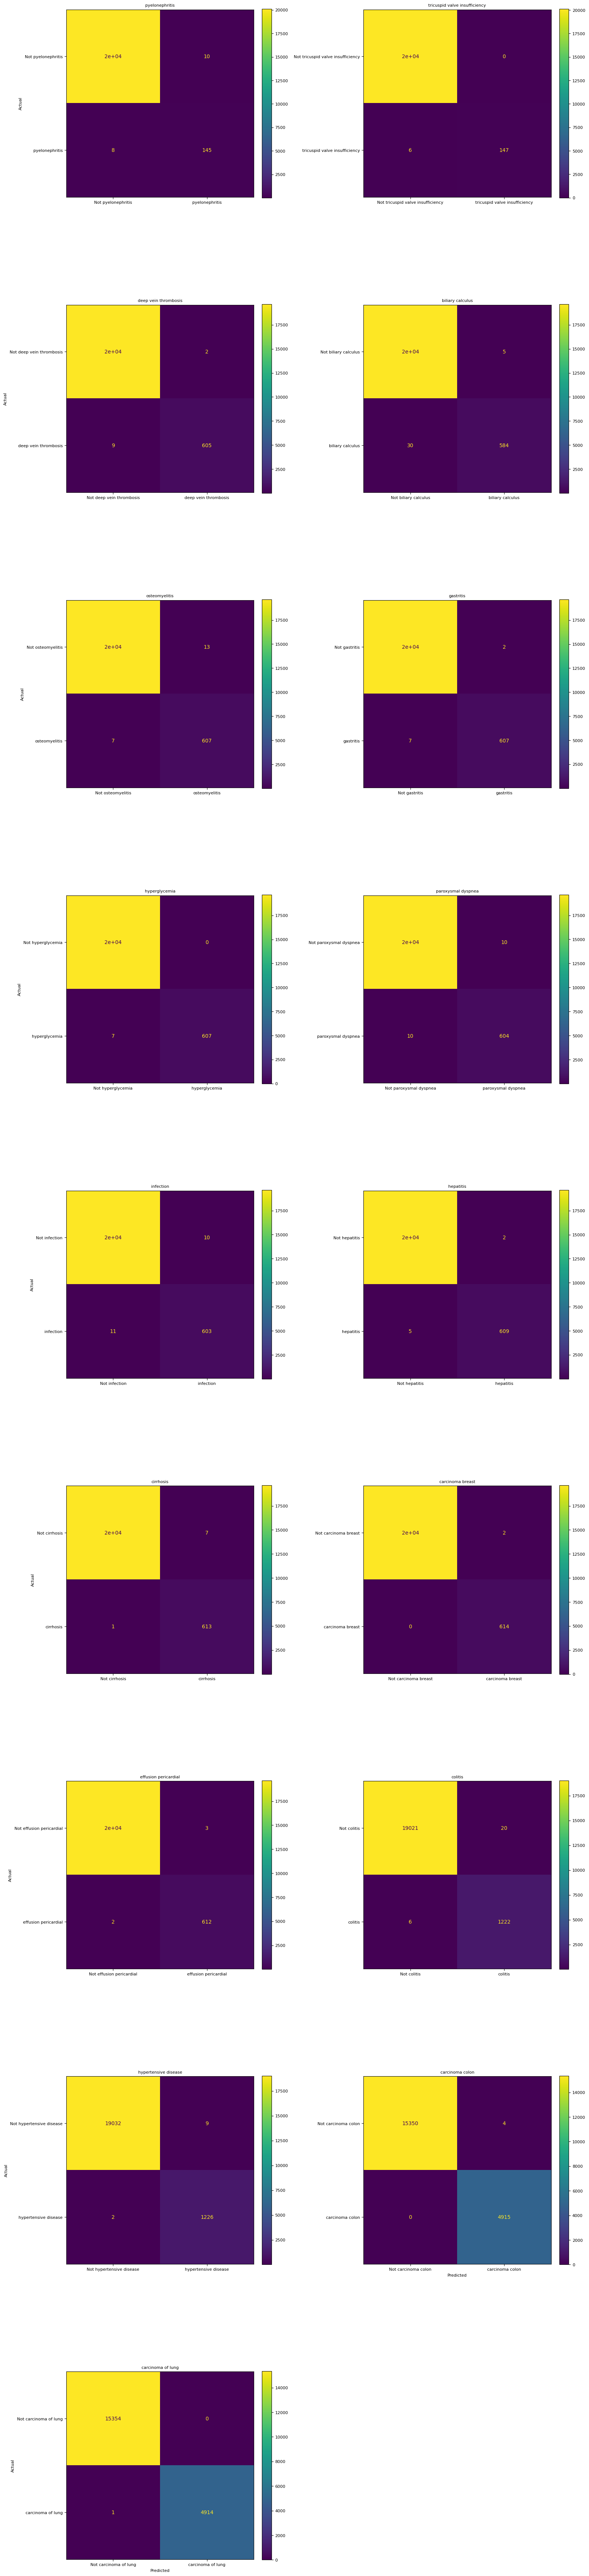

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ensure only existing diseases are considered
head_part_diseases_present = [disease for disease in head_part_diseases if disease in label_encoder.classes_]

# Plot settings
num_plots_per_row = 2
plot_size = (8, 8)

plt.figure(figsize=(plot_size[0] * num_plots_per_row, plot_size[1] * ((len(head_part_diseases_present) + num_plots_per_row - 1) // num_plots_per_row)))

for i, disease in enumerate(head_part_diseases_present):
    # Get the disease index
    disease_idx = list(label_encoder.classes_).index(disease)

    # Convert test_labels to binary for the specific disease
    y_test_binary = (test_data['encoded_labels'].to_numpy() == disease_idx).astype(int)
    y_pred_binary = (predictions == disease_idx).astype(int)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test_binary, y_pred_binary, labels=[0, 1])

    # Plot the confusion matrix
    ax = plt.subplot((len(head_part_diseases_present) + num_plots_per_row - 1) // num_plots_per_row, num_plots_per_row, i + 1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not " + disease, disease])
    disp.plot(cmap='viridis', xticks_rotation='horizontal', ax=ax, colorbar=False)
    cbar = plt.colorbar(disp.im_, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)
    ax.set_title(f"{disease}", fontsize=8)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.set_xlabel("Predicted", fontsize=8)
    ax.set_ylabel("Actual", fontsize=8)
    if i % num_plots_per_row != 0:
        ax.set_ylabel('')
    if i < len(head_part_diseases_present) - num_plots_per_row:
        ax.set_xlabel('')

plt.tight_layout()
plt.show()
